#### install MOFA if necessary

In [1]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          0.2                         
year           2020                        
month          06                          
day            22                          
svn rev        78730                       
language       R                           
version.string R version 4.0.2 (2020-06-22)
nickname       Taking Off Again            

### requirements

Either install libraries mentioned below yourself or run the following docker command in the directory with this jupyter notebook: <br> `docker run -it --rm -p 8888:8888 -v $(pwd):/home/rstudio jonasjonker/mofa2-tutorial:0.0.1`

### [tutorial](https://raw.githack.com/bioFAM/MOFA2_tutorials/master/R_tutorials/10x_scRNA_scATAC.html)
Vignette demonstrating how MOFA can be used to integrate scRNA-seq and scATAC-seq data.

### [JASPAR2020](http://jaspar.genereg.net/)
The JASPAR CORE contains a curated, non-redundant set of profiles, derived from published and experimentally defined transcription factor binding sites for eukaryotes. It should be used, when seeking models for specific factors or structural classes, or if experimental evidence is paramount. 

### [BSgenome.Hsapiens.UCSC.hg38](http://bioconductor.org/packages/release/data/annotation/html/BSgenome.Hsapiens.UCSC.hg38.html)
Full genome sequences for Homo sapiens (Human) as provided by UCSC (hg38, based on GRCh38.p12) and stored in Biostrings objects.

In [1]:
#BiocManager::install("motifmatchr") # <-- not installed in the docker image

library(data.table)
library(ggplot2)
library(magrittr)
library(Seurat)
library(Signac)
library(motifmatchr)

# for GSEA analysis
library(msigdbr)

# For motif enrichment analysis
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)

# MOFA
library(MOFA2)

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'motifmatchr'

Installation path not writeable, unable to update packages: MASS, mgcv, nlme,
  survival

Old packages: 'broom', 'coda', 'htmlwidgets', 'ragg', 'readr', 'redland',
  'rhdf5', 'rmarkdown', 'RPostgres', 'RSQLite', 'testit', 'tufte', 'vroom',
  'xaringan', 'xfun'

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, a

### load R data object

In [3]:
# seurat <- readRDS(url("ftp://ftp.ebi.ac.uk/pub/databases/mofa/10x_rna_atac_vignette/seurat.rds"))
seurat <- readRDS('seurat.rds')  # from disk
seurat  

An object of class Seurat 
138109 features across 11909 samples within 2 assays 
Active assay: RNA (29732 features, 0 variable features)
 1 other assay present: ATAC

### Inspect seurat.rds
[Seurat]("https://satijalab.org/seurat/") is an R package designed for QC, analysis, and exploration of single-cell RNA-seq data.

In [5]:
str(seurat)

Formal class 'Seurat' [package "Seurat"] with 13 slots


Warning message:
"Not a validObject(): no slot of name "images" for this object of class "Seurat""


  ..@ assays      :List of 2
  .. ..$ RNA :Formal class 'Assay' [package "Seurat"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:23508033] 9 36 41 47 72 91 95 107 127 129 ...
  .. .. .. .. .. ..@ p       : int [1:11910] 0 3308 5204 8108 8954 11236 12589 15650 17341 20369 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 29732 11909
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:29732] "AL627309.1" "AL627309.2" "AL627309.5" "AL627309.4" ...
  .. .. .. .. .. .. ..$ : chr [1:11909] "AAACAGCCAAGGAATC" "AAACAGCCAATCCCTT" "AAACAGCCAATGCGCT" "AAACAGCCACACTAAT" ...
  .. .. .. .. .. ..@ x       : num [1:23508033] 1 1 1 1 1 1 1 1 1 6 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:23508033] 9 36 41 47 72 91 95 107 127 129 ...
  .. .. .. .. .. ..@ p       : int [1:11910]

In [11]:
head (seurat@meta.data, 1)
head(seurat@meta.data[,c("celltype","broad_celltype","pass_rnaQC","pass_accQC")], 1)
table(seurat@meta.data$celltype)
table(seurat@meta.data$broad_celltype)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,celltype,pass_rnaQC,pass_accQC,broad_celltype
,<fct>,<dbl>,<int>,<dbl>,<int>,<chr>,<lgl>,<lgl>,<chr>
AAACAGCCAAGGAATC,scRNA+scATAC PBMC,8380,3308,55582,13878,naive CD4 T cells,TRUE,TRUE,Lymphoid


,celltype,broad_celltype,pass_rnaQC,pass_accQC
,<chr>,<chr>,<lgl>,<lgl>
AAACAGCCAAGGAATC,naive CD4 T cells,Lymphoid,TRUE,TRUE



 CD56 (bright) NK cells     CD56 (dim) NK cells     classical monocytes 
                    407                     472                    1929 
   effector CD8 T cells  intermediate monocytes            MAIT T cells 
                    385                     664                     106 
         memory B cells      memory CD4 T cells              myeloid DC 
                    420                    1611                     242 
          naive B cells       naive CD4 T cells       naive CD8 T cells 
                    295                    1462                    1549 
non-classical monocytes         plasmacytoid DC 
                    383                     107 


Lymphoid  Myeloid 
    6814     3218 

### filter low quality data

In [5]:
seurat
seurat <- seurat %>%
  .[,seurat@meta.data$pass_accQC==TRUE & seurat@meta.data$pass_rnaQC==TRUE]  # filter data
seurat

An object of class Seurat 
138109 features across 11909 samples within 2 assays 
Active assay: RNA (29732 features, 0 variable features)
 1 other assay present: ATAC

An object of class Seurat 
138109 features across 10032 samples within 2 assays 
Active assay: RNA (29732 features, 0 variable features)
 1 other assay present: ATAC

In [14]:
seurat@assays$RNA
seurat@assays$ATAC

Assay data with 29732 features for 11909 cells
First 10 features:
 AL627309.1, AL627309.2, AL627309.5, AL627309.4, AP006222.2, AL669831.2,
LINC01409, FAM87B, LINC01128, LINC00115 

Assay data with 108377 features for 11909 cells
First 10 features:
 chr1:10109-10357, chr1:180730-181630, chr1:191491-191736,
chr1:267816-268196, chr1:586028-586373, chr1:629721-630172,
chr1:633793-634264, chr1:777634-779926, chr1:816881-817647,
chr1:819912-823500 

### Load and attach metadata

In [15]:
feature_metadata <- fread("ftp://ftp.ebi.ac.uk/pub/databases/mofa/10x_rna_atac_vignette/filtered_feature_bc_matrix/features.tsv.gz") %>%
  setnames(c("ens_id","gene","view","chr","start","end"))

In [16]:
feature_metadata.rna <- feature_metadata[view=="Gene Expression"]
head(feature_metadata.rna,n=3)

ens_id,gene,view,chr,start,end
<chr>,<chr>,<chr>,<chr>,<int>,<int>
ENSG00000243485,MIR1302-2HG,Gene Expression,chr1,29553,30267
ENSG00000237613,FAM138A,Gene Expression,chr1,36080,36081
ENSG00000186092,OR4F5,Gene Expression,chr1,65418,69055


In [17]:
feature_metadata.atac <-
    feature_metadata[view=="Peaks"] %>%  # Filter Peaks
    .[,ens_id:=NULL] %>%                 # Update their ens_i to NULL
    setnames("gene","peak")              # rename column gene to peak
head(feature_metadata.atac,n=3)
table(feature_metadata.atac$view)

peak,view,chr,start,end
<chr>,<chr>,<chr>,<int>,<int>
chr1:10109-10357,Peaks,chr1,10109,10357
chr1:180730-181630,Peaks,chr1,180730,181630
chr1:191491-191736,Peaks,chr1,191491,191736



 Peaks 
108377 

In [18]:
foo <- fread("ftp://ftp.ebi.ac.uk/pub/databases/mofa/10x_rna_atac_vignette/atac_peak_annotation.tsv") %>%
  .[,c("peak","peak_type")] %>%
  .[peak_type%in%c("distal", "promoter")]

feature_metadata.atac <- feature_metadata.atac %>% 
  merge(foo,by="peak",all.x=TRUE)

head(feature_metadata.atac, n=3)

table(feature_metadata.atac$peak_type)
table(feature_metadata.atac$view)

peak,view,chr,start,end,peak_type
<chr>,<chr>,<chr>,<int>,<int>,<chr>
GL000194.1:101218-101619,Peaks,GL000194.1,101218,101619,distal
GL000194.1:114724-115221,Peaks,GL000194.1,114724,115221,promoter
GL000194.1:28230-28519,Peaks,GL000194.1,28230,28519,distal



  distal promoter 
   91822    16074 


 Peaks 
108377 

### create motif matrix
[Create motif matrix](https://satijalab.org/signac/reference/CreateMotifMatrix.html)

In [19]:
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(species = "9606", all_versions = FALSE, matrixtype = "PFM")  ## matrixtype = "PWM" is also fine for our purposes
)
pfm

PFMatrixList of length 633
names(633): MA0030.1 MA0031.1 MA0051.1 MA0057.1 ... MA0748.2 MA0528.2 MA0609.2

#### know thy data

In [15]:
pfm$`MA0030.1`

An object of class PFMatrix
ID: MA0030.1
Name: FOXF2
Matrix Class: Fork head / winged helix factors
strand: +
Tags: 
$alias
[1] "FREAC2"

$description
[1] "forkhead box F2"

$family
[1] "Forkhead box (FOX) factors"

$medline
[1] "7957066"

$symbol
[1] "FOXF2"

$tax_group
[1] "vertebrates"

$tfbs_shape_id
[1] "37"

$type
[1] "SELEX"

$collection
[1] "CORE"

$species
          9606 
"Homo sapiens" 

$acc
[1] "Q12947"

Background: 
   A    C    G    T 
0.25 0.25 0.25 0.25 
Matrix: 
  [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13] [,14]
A    1   10   17   13    3    7    0   27   27    27     0    27    16     7
C   10    7    4    5   11    0    0    0    0     0    25     0     4     4
G    7    5    2    5    8   20    0    0    0     0     0     0     2     6
T    9    5    4    5    0    0   27    0    0     0     2     0     5    10

In [16]:
# BSgenome.Hsapiens.UCSC.hg38 contains full chromosomes and contigs.
BSgenome.Hsapiens.UCSC.hg38$chr1_GL383518v1_alt


182439-letter DNAString object
seq: CTATAATCCCAGCTTGTTGGGAGGCCAAGGCAGGAG...TAATCAGACTAAAAATACCAGAGGCAATTTGAATTC

### test creation of GRanges object

In [21]:
peaks.granges <- feature_metadata.atac %>%
    .[peak_type=="distal"] %>%
    makeGRangesFromDataFrame(keep.extra.columns = TRUE, ignore.strand = TRUE)

In [22]:
str(peaks.granges)
table(peaks.granges@seqnames)

Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. ..@ values         : Factor w/ 31 levels "chr1","chr2",..: 24 25 26 27 28 29 30 31 10 11 ...
  .. .. ..@ lengths        : int [1:31] 3 2 6 10 6 1 1 1 4324 4380 ...
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. ..@ start          : int [1:91822] 101218 28230 56140 24252 30140 140550 62326 67888 70583 87914 ...
  .. .. ..@ width          : int [1:91822] 402 290 52 26 3216 466 2345 1742 286 370 ...
  .. .. ..@ NAMES          : NULL
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ strand         :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. ..@ values         : Factor w/ 3 levels "+","-","*": 3
  .. .. ..@ lengths        : int 91822
  .. .. ..@ elementMetad


      chr1       chr2       chr3       chr4       chr5       chr6       chr7 
      8861       7382       5877       3653       4587       5772       4475 
      chr8       chr9      chr10      chr11      chr12      chr13      chr14 
      3827       3731       4324       4380       4813       2079       3131 
     chr15      chr16      chr17      chr18      chr19      chr20      chr21 
      2994       3354       4805       1776       3751       2686       1177 
     chr22       chrX GL000194.1 GL000195.1 GL000205.2 GL000219.1 KI270713.1 
      2014       2343          3          2          6         10          6 
KI270726.1 KI270727.1 KI270734.1 
         1          1          1 

### Remove unlocalized contigs

In [24]:
peaks.granges <- keepStandardChromosomes(peaks.granges, pruning.mode="coarse")
table(peaks.granges@seqnames)


 chr1  chr2  chr3  chr4  chr5  chr6  chr7  chr8  chr9 chr10 chr11 chr12 chr13 
 8861  7382  5877  3653  4587  5772  4475  3827  3731  4324  4380  4813  2079 
chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22  chrX 
 3131  2994  3354  4805  1776  3751  2686  1177  2014  2343 

### generate GRanges and motif matrix
this step takes some time.

In [25]:
for (i in c("distal","promoter")) {
  peaks.granges <- feature_metadata.atac %>%
    .[peak_type==i] %>%
    .[,c("chr","start","end","peak")] %>%
    makeGRangesFromDataFrame(keep.extra.columns = TRUE, ignore.strand = TRUE)
    
  # prevents error due to different naming conventions of unlocalized contigs by removing them.
  peaks.granges <- keepStandardChromosomes(peaks.granges, pruning.mode="coarse")
    
  # Scan motifs throughout the DNA sequence of each peak and create a binary matrix of motif-peak presence.
  motif.matrix <- Signac::CreateMotifMatrix(
    features = peaks.granges,               # GRanges object containing a set of genomic features
    pwm = pfm,                              # PFMatrixList/PWMatrixList object containing position weight/frequency matrices
    genome = BSgenome.Hsapiens.UCSC.hg38,   # Object compatible with genome argument in motifmatchr::matchMotifs
    use.counts = FALSE                      # default
  ) %>% as.matrix
  
  # AddChromatinAssay to the Seurat object
  seurat@assays[[paste0("ATAC_",i)]] <- CreateChromatinAssay(
    seurat@assays$ATAC@counts[peaks.granges$peak,], 
    ranges = peaks.granges,
    motifs = CreateMotifObject(motif.matrix, pfm)
  )
  
}
# saveRDS(seurat, "seurat_with_motif_matrix.rds")
seurat

Warning message in rownames(x = object) == rownames(x = new.data):
"longer object length is not a multiple of shorter object length"
Warning message in SetAssayData.ChromatinAssay(object = new.assay, slot = "motifs", :
"Features do not match in ChromatinAssay and Motif object.
                Subsetting the Motif object."
Warning message in rownames(x = object) == rownames(x = new.data):
"longer object length is not a multiple of shorter object length"
Warning message in SetAssayData.ChromatinAssay(object = new.assay, slot = "motifs", :
"Features do not match in ChromatinAssay and Motif object.
                Subsetting the Motif object."


An object of class Seurat 
245458 features across 11909 samples within 4 assays 
Active assay: RNA (29732 features, 0 variable features)
 3 other assays present: ATAC, ATAC_distal, ATAC_promoter

In [4]:
seurat <- readRDS('seurat_with_motif_matrix.rds')  # skip data prep.

In [5]:
seurat <- NormalizeData(seurat, normalization.method = "LogNormalize", assay = "RNA")
seurat <- ScaleData(seurat, do.center = TRUE, do.scale = FALSE)


Centering data matrix



In [6]:
for (i in c("ATAC_distal","ATAC_promoter")) {
  seurat <- RunTFIDF(seurat, assay = i)
}

Performing TF-IDF normalization

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from atac_distal_ to atacdistal_"
Performing TF-IDF normalization

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from atac_promoter_ to atacpromoter_"


In [7]:
seurat <- FindVariableFeatures(seurat, 
  selection.method = "vst", 
  nfeatures = 5000,
  assay = "RNA",
  verbose = FALSE
)

In [8]:
for (i in c("ATAC_distal","ATAC_promoter")) {
  seurat <- FindTopFeatures(seurat, assay=i, min.cutoff = 2000)
  print(length(seurat[[i]]@var.features))
}

[1] 10721
[1] 11646


### save prepped data before proceeding to next step

In [9]:
saveRDS(seurat, "seurat_prepped.rds")

### clear memory, because jupyter kept crashing in next steps

In [10]:
gc()

Warning message:
"'memory.size()' is Windows-specific"


[1] Inf

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,13049195,697.0,23490667,1254.6,15502831,828.0
Vcells,932488373,7114.4,1457284296,11118.2,1439080965,10979.4


Warning message:
"'memory.size()' is Windows-specific"


[1] Inf

### create mofa object

In [11]:
mofa <- create_mofa(seurat, assays = c("RNA","ATAC_distal","ATAC_promoter"))
mofa

Creating MOFA object from a Seurat object...

No features specified, using variable features from the Seurat object...

No groups provided as argument... we assume that all samples are coming from the same group.




Untrained MOFA model with the following characteristics: 
 Number of views: 3 
 Views names: RNA ATAC_distal ATAC_promoter 
 Number of features (per view): 5000 10721 11646 
 Number of groups: 1 
 Groups names: group1 
 Number of samples (per group): 11909 


In [12]:
model_opts <- get_default_model_options(mofa)
model_opts$num_factors <- 15

In [13]:
mofa <- prepare_mofa(mofa,
  model_options = model_opts
)

Warning message in prepare_mofa(mofa, model_options = model_opts):
"Some view(s) have a lot of features, it is recommended to performa more stringent feature selection before creating the MOFA object...."
Checking data options...

No data options specified, using default...

No training options specified, using default...

Checking model options...



### train mofa object (this step takes hours)

In [14]:
# saveRDS(mofa, "mofa.rds")

In [1]:
mofa <- readRDS('mofa.rds') 

In [ ]:
# run `pip install mofapy2==0.5.6` in bash if mofapy2 is not installed
######  mofa <- run_mofa(mofa) # jupyter keep crashing. Use terminal for this step.

# 9 MOFA downstream analysis

## 9.1 Add cell metadata to the model

The sample metadata must be provided as a data.frame and it must contain a column named sample with the sample IDs.

In [4]:
samples_metadata(mofa) <- seurat@meta.data %>%
  tibble::rownames_to_column("sample") %>%
  as.data.table

ERROR: Error in seurat@meta.data %>% tibble::rownames_to_column("sample") %>% : could not find function "%>%"


Asses the correlation between factors

A good sanity check is to verify that the Factors are largely uncorrelated. In MOFA there are no orthogonality constraints such as in Principal Component Analysis, but if there is a lot of correlation between Factors this suggests a poor model fit


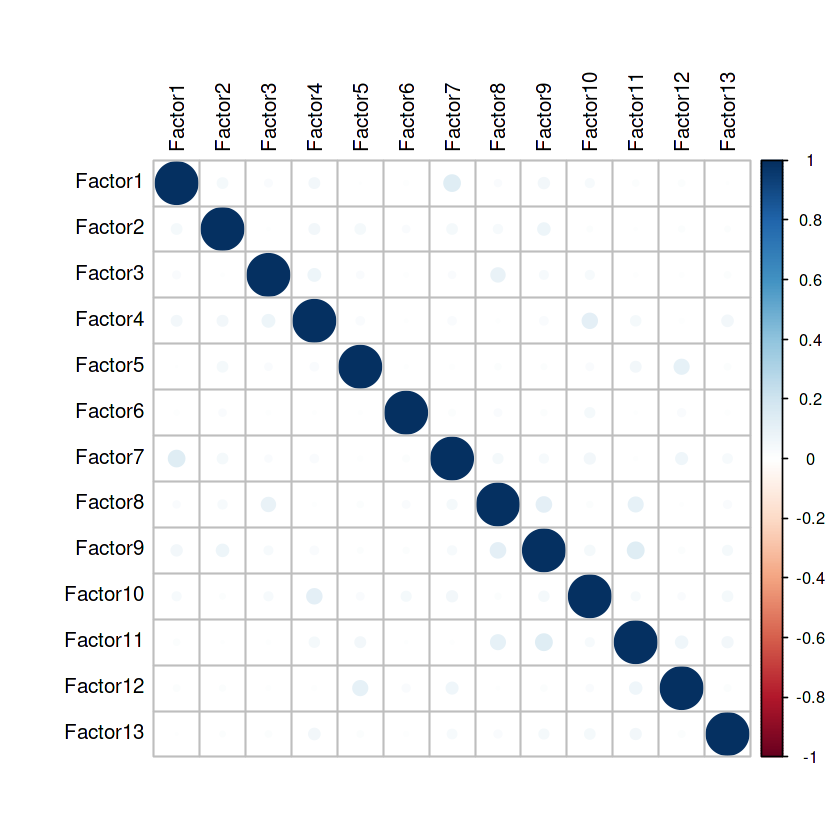

In [5]:
plot_factor_cor(mofa)

## 9.2 Variance decomposition

The variance decomposition analysis is my favourite MOFA functionality. It calculates the percentage of variance explained by each factor and data modality. What insight can we learn just from visualising this? Factor 1 has a very strong signal from all data modalities, so it must be the most important source of variability in the data. Factor 2 and Factor 3 are weaker but also shared between all data modalities, so they are also likely to be impotant sources of variability. Interestingly, most Factors have a stronger signal in distal peaks than in promoter peaks.

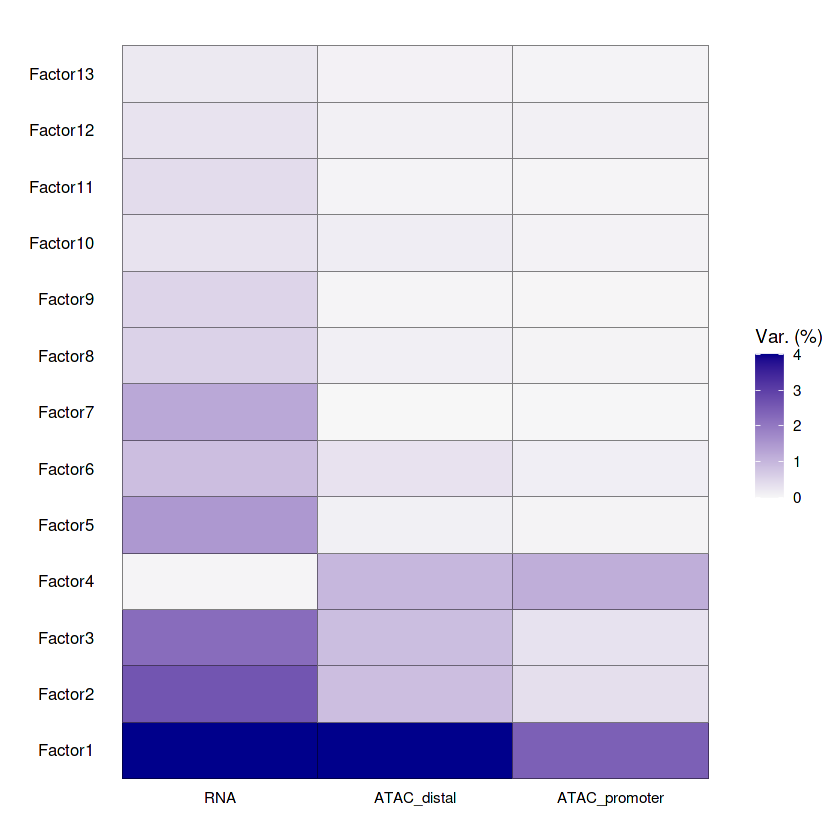

In [6]:
plot_variance_explained(mofa, max_r2 = 4)

A reasonable question is whether the model is providing a good fit to the data. To assess this we can plot the total variance explained (using all factors). The resulting values will depend on the nature of the data set, the number of samples, the number of factors, etc. For single-cell data the values tend to be quite low. Here we have a 30% for RNA, a very reasonable value, versus ~8-10% for ATAC data, which is also a decent value taking into account how noisy scATAC data is. In fact, compared to my previous analysis on the SNARE-seq data set these are very good values. In the SNARE-seq analysis the the ATAC modality was extremely noisy and we had to rely on denoising strategies to get meaningful signal. As you’ll see in this vignette, the 10x Genomics technology provides much better quality measurements and no denoising strategy is required.

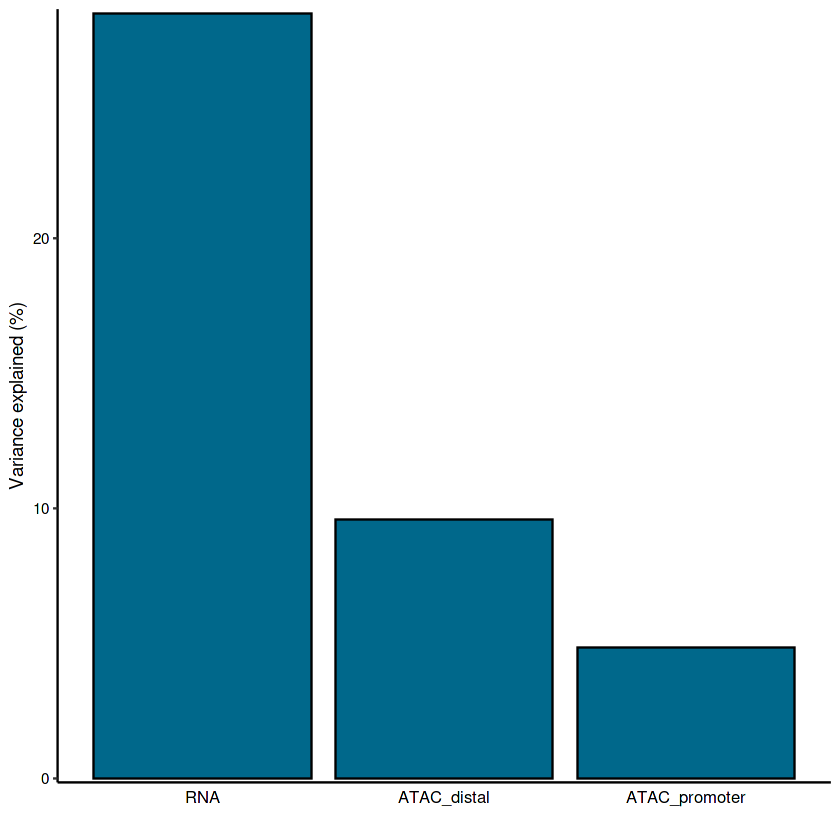

In [7]:
plot_variance_explained(mofa, plot_total = TRUE)[[2]]

## 9.4 Characterisation of Factors

There are a few systematic strategies to characterise the molecular etiology underlying each MOFA Factor:

Association analysis between cell covariates and Factor values.

Visualisation of factor values.

Visualisation of feature weights.

Gene set enrichment analysis.

## 9.3 Correlate factors with covariates

As a first approach, let’s correlate the standard quality control metrics with the Factor values. We see that Factor 4 is strongly associated with the number of expressed genes per cell and the Factors 1 and 7 are associated with the number of accessible peaks per cell. Some of these are likely technical factors that should be removed with a better normalisation strategy.

In [8]:
#install.packages('psych')
#library(psych)

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)


Attaching package: 'psych'


The following objects are masked from 'package:ggplot2':

    %+%, alpha




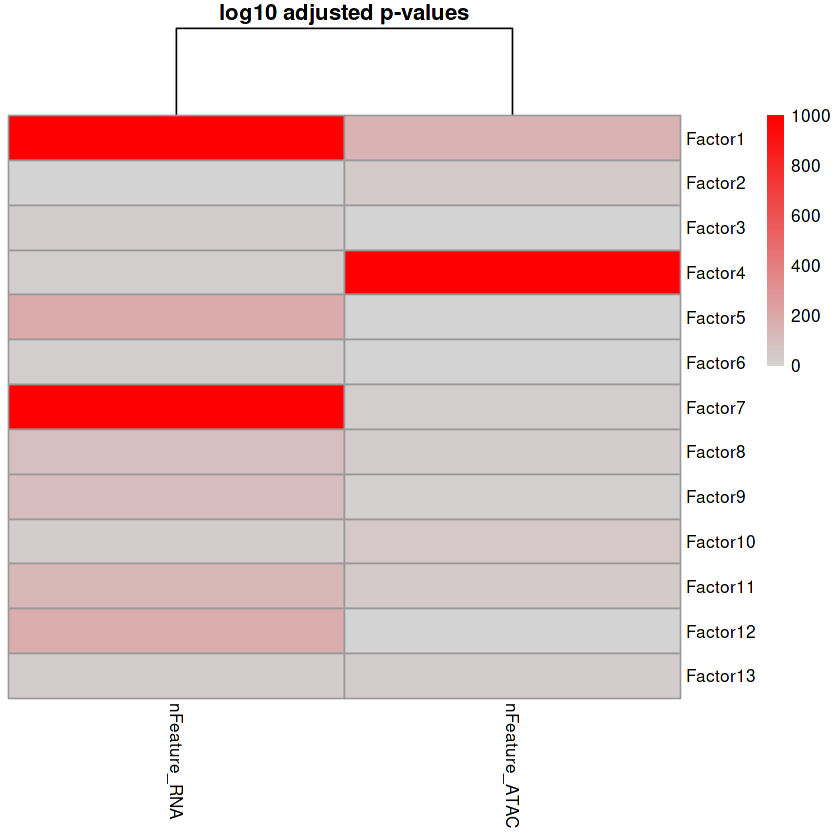

In [9]:
correlate_factors_with_covariates(mofa, covariates = c("nFeature_RNA","nFeature_ATAC"))

## 9.4 Characterisation of Factor 1

The variance expalined plot tells us that Factor 1 is the strongest source of variation and has a large contribution from all data modalities.

### 9.4.2.1 Visualisation of Factor values

How do we interpret the factor values?
Mathematically, each Factor is defined by a linear combination of the input features. As the data is centered prior to running MOFA, each Factor ordinates cells along a one-dimensional axis that is centered at zero. Samples with different signs manifest opposite “effects” along the inferred axis of variation, with higher absolute value indicating a stronger effect. Note that the interpretation of MOFA factors is analogous to the interpretation of the principal components in PCA.

Let’s plot the Factor 1 values grouped by cell type and coloured by lineage of origin (Lymphoid or Myeloid). Clearly Factor 1 captures the molecular variation associated with lineage of origin.

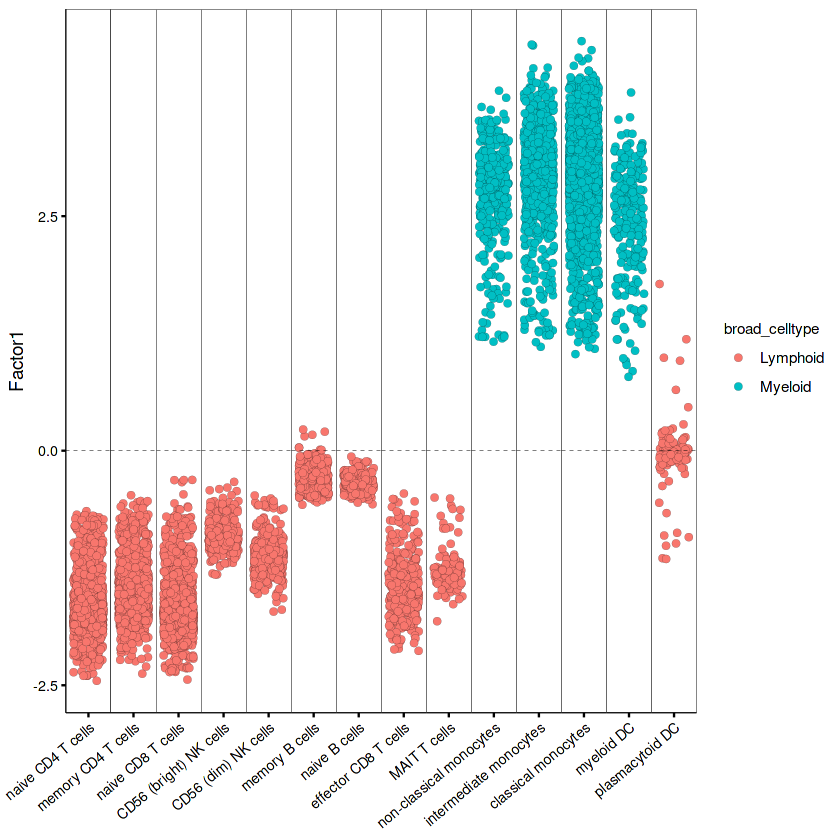

In [10]:
plot_factor(mofa, factors=1, group_by = "celltype", color_by="broad_celltype") +
  theme(
    axis.text.x = element_text(color="black", angle=40, vjust=1, hjust=1)
  )

### 9.4.2.2 Visualisation of feature weights

how do we interpret the weights?
The weights provide a score for each feature on each factor. Features with no association with the corresponding factor are expected to have values close to zero, whereas features with strong association with the factor are expected to have large absolute values. The sign of the weights indicates the direction of the effect: a positive weights indicates that the feature has higher levels in the cells with positive factor values, and vice-versa.

Let’s plot the associated RNA weights. These are all good markers of myeloid (LYN, SLC8A1, LYZ, etc.) vs lymphoid fate (BCL11B)

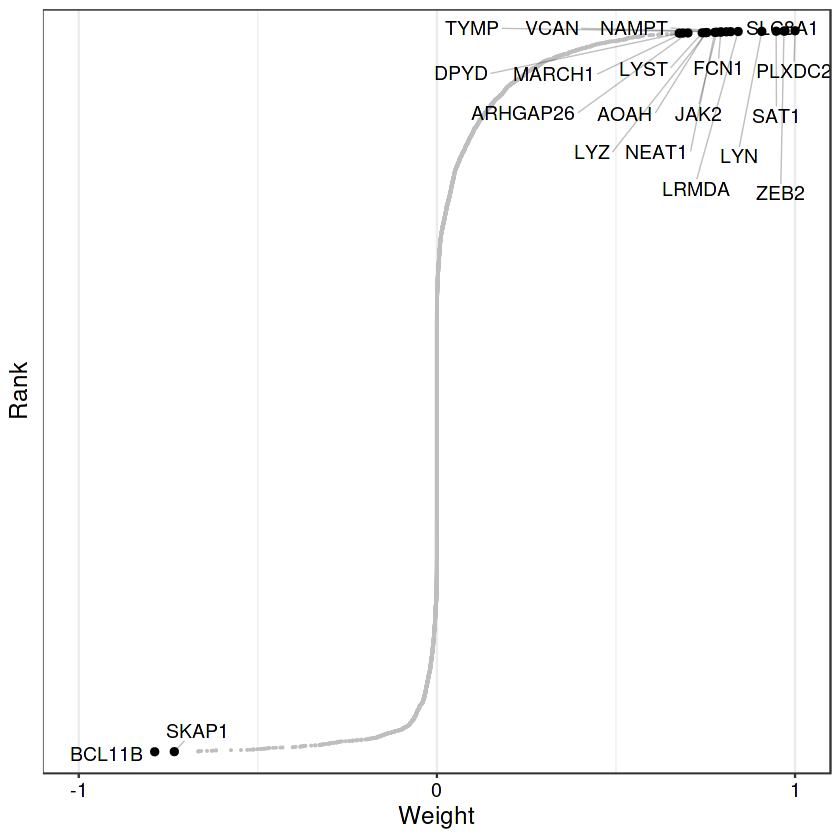

In [11]:
plot_weights(mofa, 
  view = "RNA", 
  factors = 1, 
  nfeatures = 20, 
  text_size = 4
)

### 9.4.2.3 Visualisation covariation patterns in the input data

The weights are useful to get an idea of which genes are driving each factor. However, to get an idea of how good the association between features and factors is we can generate a scatterplot of the Factor values against mRNA expression for the genes with the largest weights:

In [13]:
# install.packages('ggpubr')

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

also installing the dependencies 'zip', 'SparseM', 'MatrixModels', 'conquer', 'openxlsx', 'minqa', 'nloptr', 'statmod', 'carData', 'pbkrtest', 'quantreg', 'rio', 'lme4', 'car', 'ggsci', 'ggsignif', 'polynom', 'rstatix'




In [14]:
# library('ggpubr')

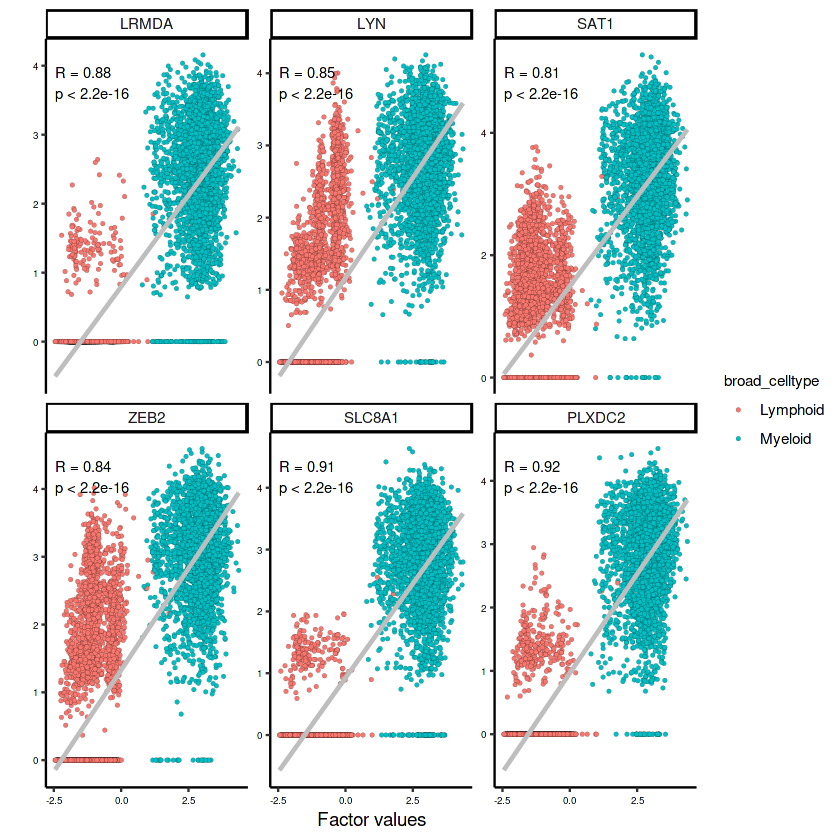

In [15]:
plot_data_scatter(mofa, 
  view = "RNA", 
  factor = 1, 
  features = 6,
  color_by = "broad_celltype",
  add_lm = T,
  dot_size = 1
)

Now let’s visualise the ATAC signatures by inspecting the weights, although they are not very interpretable. We’ll have to rely on motif-based approaches to get TF/motif signatures.

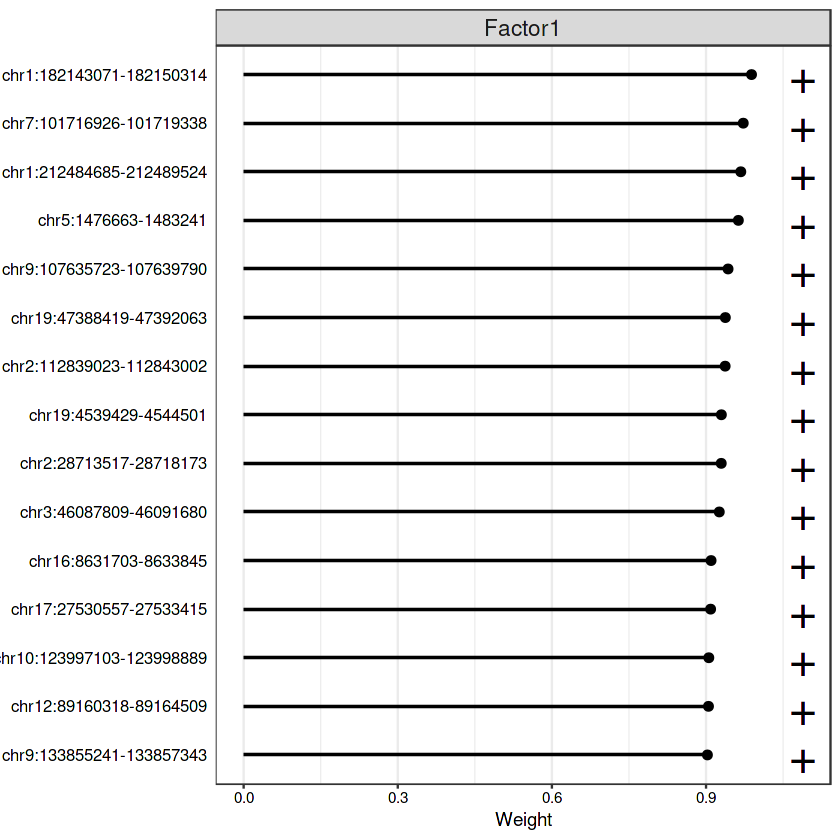

In [16]:
plot_top_weights(mofa, 
  view = "ATAC_distal", 
  factors = 1, 
  sign = "positive",
  nfeatures = 15,
)

Again, we can visualise the ATAC patterns recovered by MOFA on the high-dimensional space. Instead of scatterplots we can use heatmaps:

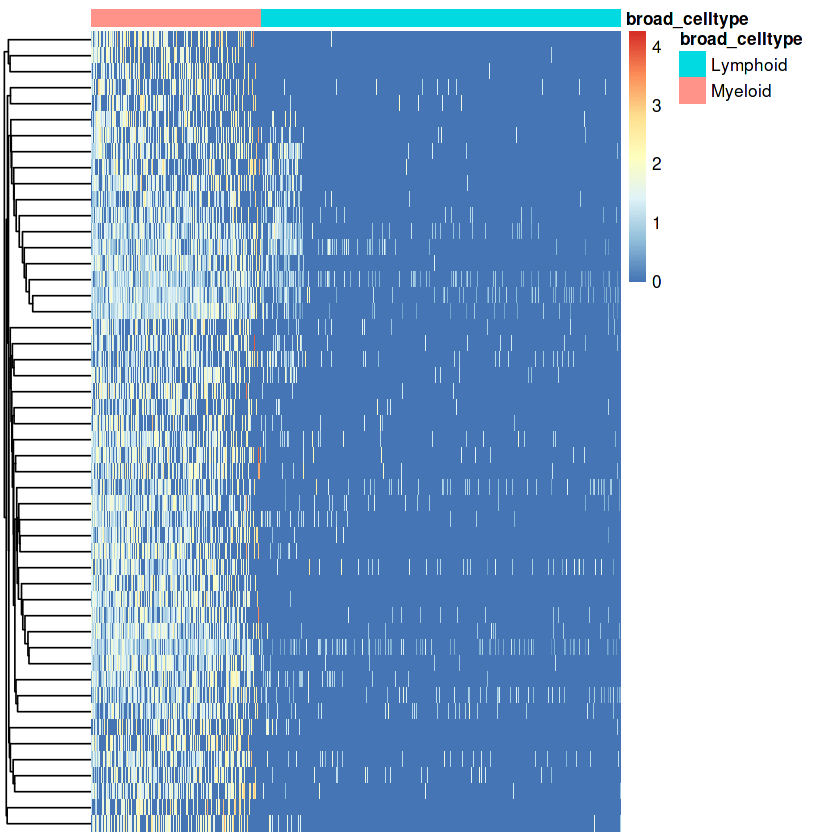

In [17]:
plot_data_heatmap(mofa, 
  view = "ATAC_promoter", 
  factor = 1, 
  features = 50,
  show_rownames = F, show_colnames = F, 
  cluster_rows = T, cluster_cols = F,
  annotation_samples = "broad_celltype"
)

Again, we can visualise the ATAC patterns recovered by MOFA on the high-dimensional space. Instead of scatterplots we can also use heatmaps:

MOFA has an interesting option to denoise/smooth the data by reconstructing the data modalities using the latent factors. We can check how this works in the plot_data_heatmap function using denoise = TRUE. Instead of plotting the (noisy) input data, this plots the data reconstructed by the model:

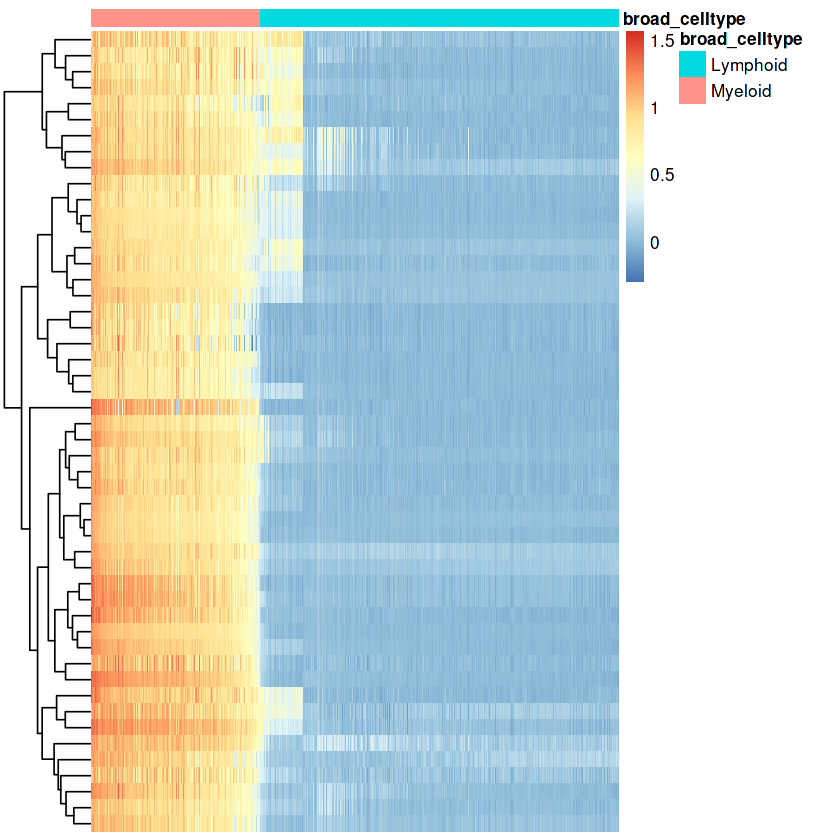

In [18]:
plot_data_heatmap(mofa, 
  view = "ATAC_promoter", 
  factor = 1, 
  features = 50,
  show_rownames = F, show_colnames = F, 
  cluster_rows = T, cluster_cols = F,
  annotation_samples = "broad_celltype",
  denoise = TRUE
)

## 9.4.3 Characterisation of Factor 2

Let’s proceed now in a similar way to characterise Factor 2. It is clearly capturing B cell commitment

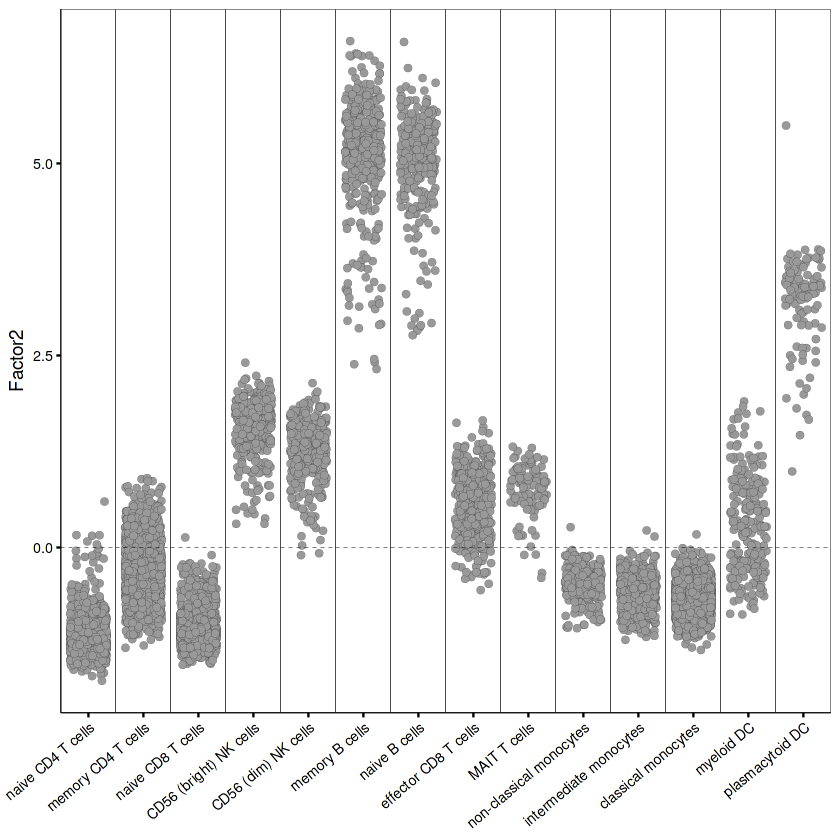

In [19]:
plot_factor(mofa, factors=2, group_by = "celltype") +
  theme(
    axis.text.x = element_text(color="black", angle=40, vjust=1, hjust=1)
  )

Let’s plot the associated RNA weights. We see good B cell markers, including CD74 and BANK1



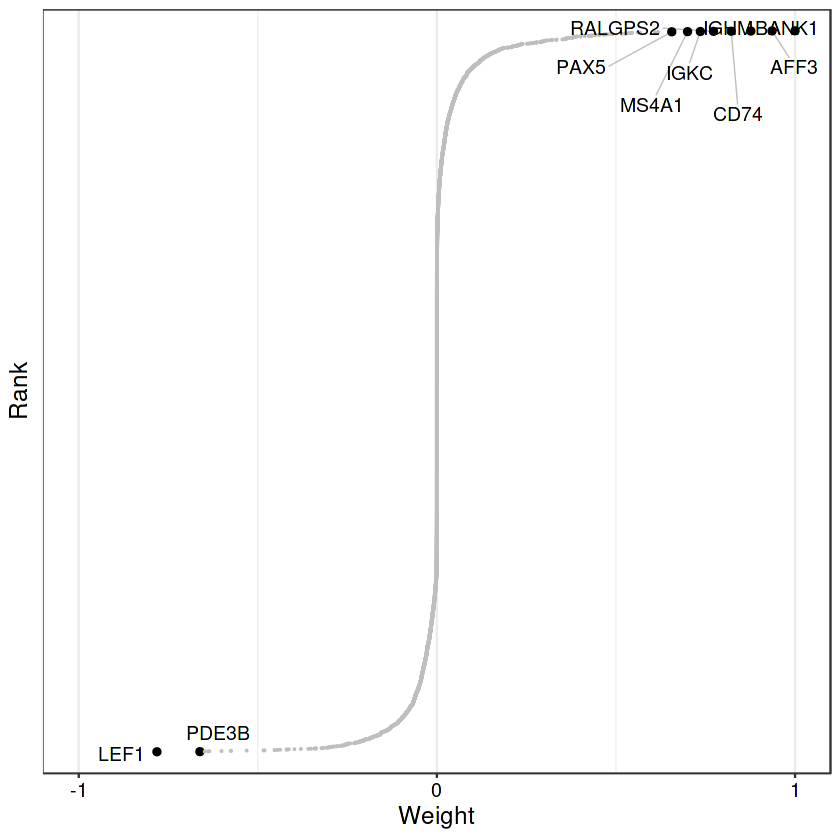

In [20]:
plot_weights(mofa, 
  view = "RNA", 
  factors = 2, 
  nfeatures = 10, 
  text_size = 4
)

Let’s color the factor values by BANK1 expression

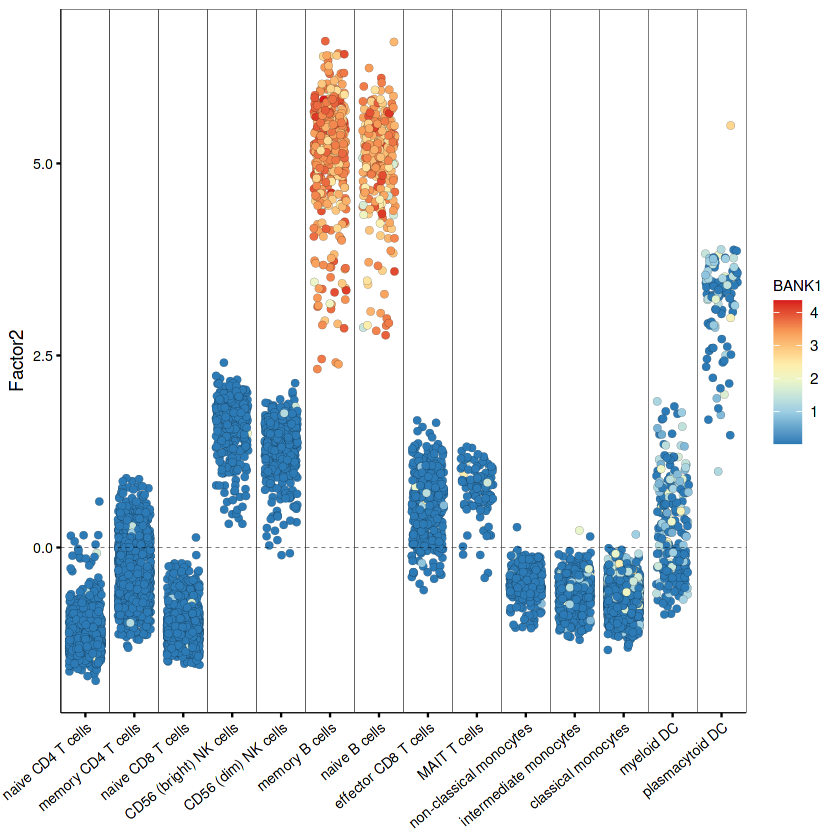

In [21]:
plot_factor(mofa, factors=2, group_by = "celltype", color_by="BANK1") +
  theme(
    axis.text.x = element_text(color="black", angle=40, vjust=1, hjust=1)
  )

Again, we can visualise the ATAC signatures:

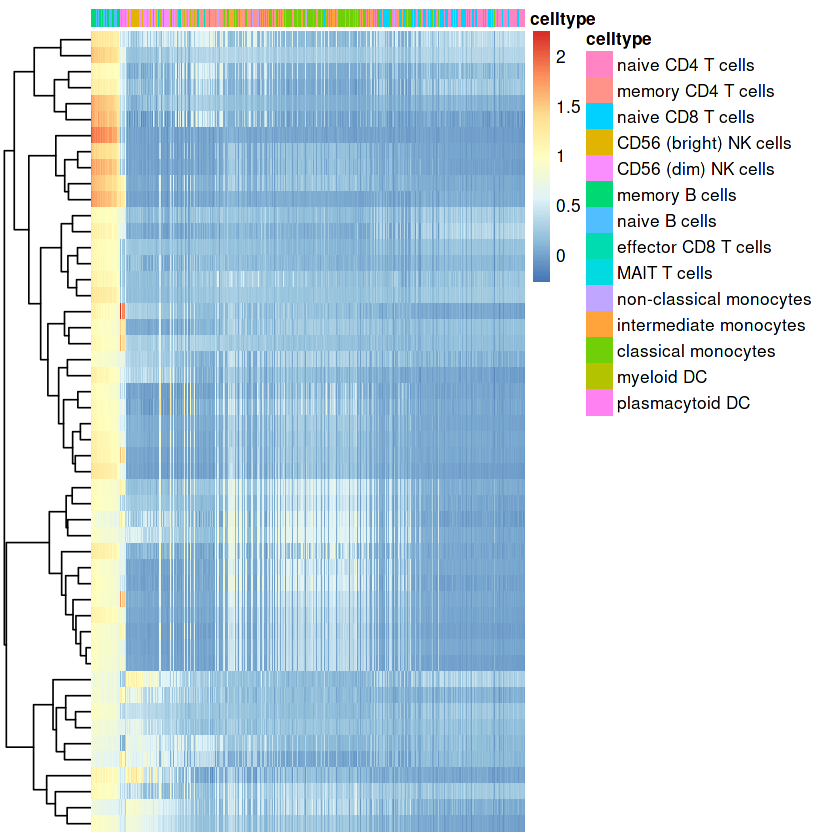

In [22]:
plot_data_heatmap(mofa, 
  view = "ATAC_promoter", 
  factor = 2, 
  features = 50,
  show_rownames = F, show_colnames = F, 
  cluster_rows = T, cluster_cols = F,
  annotation_samples = "celltype",
  denoise = TRUE
)

9.4.4 Characterisation of Factor 4

In the correlation analysis we found that Factor 4 is strongly correlated to the total number of ATAC peaks, so it is likely a technical source of variation that has not been removed in the normalisation steps. The signal is clear, and it affects all cell types in a similar fashion:

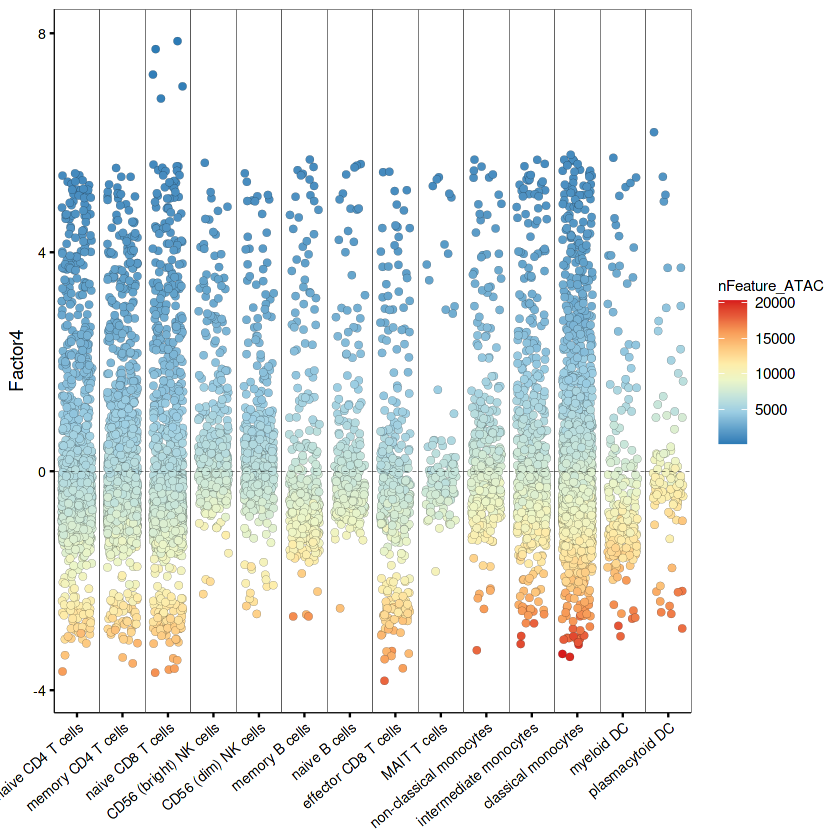

In [23]:
plot_factor(mofa, factors=4, group_by = "celltype", color_by="nFeature_ATAC") +
  theme(
    axis.text.x = element_text(color="black", angle=40, vjust=1, hjust=1)
  )

If we plot the associated ATAC weights notice that the distribution is massively shifted towards negative values. A typical signature of a technical factor is that most of the weights tend to non-zero:

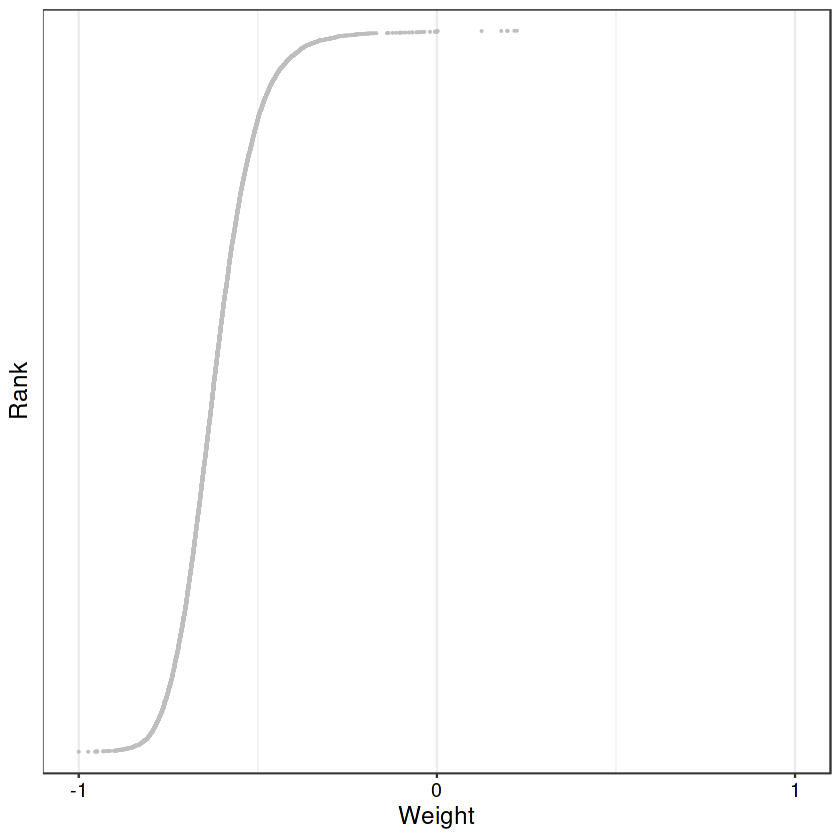

In [24]:
plot_weights(mofa, 
  view = "ATAC_promoter", 
  factors = 4, 
  nfeatures = 0, 
  text_size = 4
)

## 9.5 Non-linear dimensionality reduction

### 9.5.1 Using MOFA factors

The latent space inferred by MOFA can replace the PCA embedding as input to algorithms that learn non-linear manifolds such as t-SNE or UMAP. This can be very useful to identify cellular populations and reconstruct complex pseudotime trajectories. The advantage of MOFA is that (1) we use information from all available omics, and (2) we can characterise the Factors and remove the technical ones.

In [28]:
#colors()

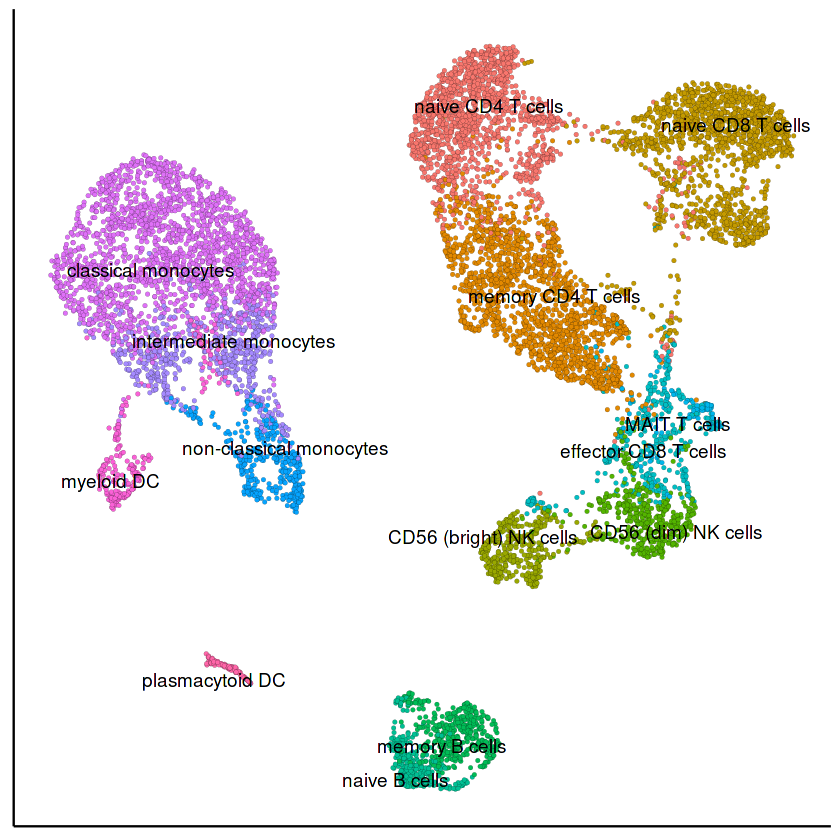

In [29]:
factors <- 1:get_dimensions(mofa)[["K"]]
factors <- factors[!factors%in%c(4,7)]

mofa <- run_umap(mofa, 
  factors = factors, 
  n_neighbors = 15,  
  min_dist = 0.30
)

plot_dimred(mofa, 
  method = "UMAP", 
  color_by = "celltype", 
  label = TRUE, 
  stroke=0.05, 
  dot_size = 1, 
  legend = FALSE
) #+ scale_fill_manual(values=colors)      


# ToDo: does scale_fill_manual this has a specific function other than colouring it manually
# figures look differently than on the tutorial website

We can try to add some interpretatibility on the UMAP by visualising the contribution of each Factor on the different groups of cells.

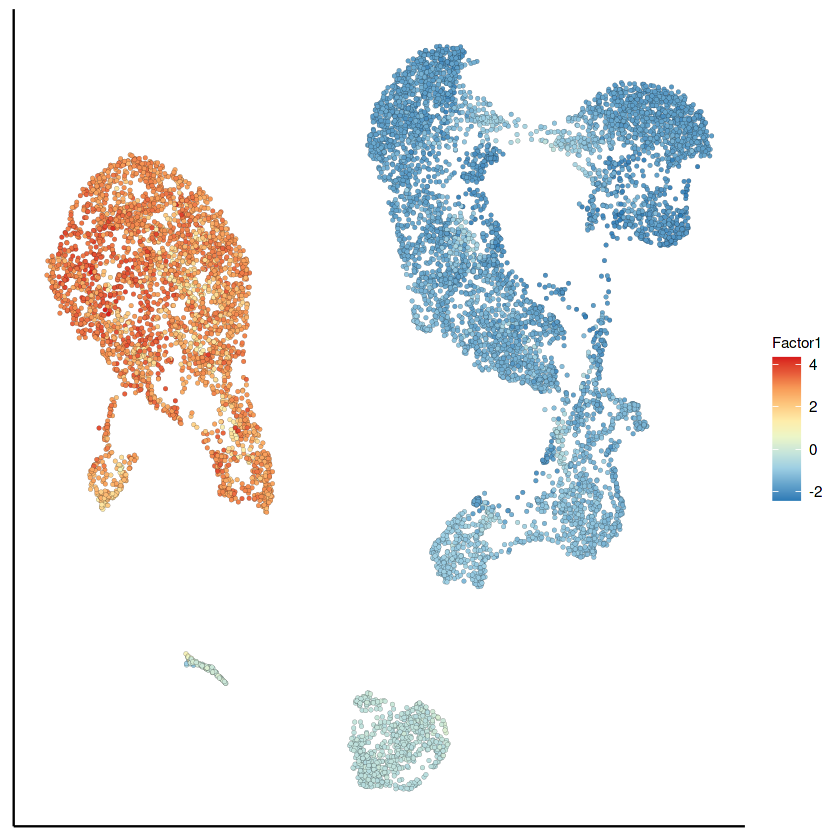

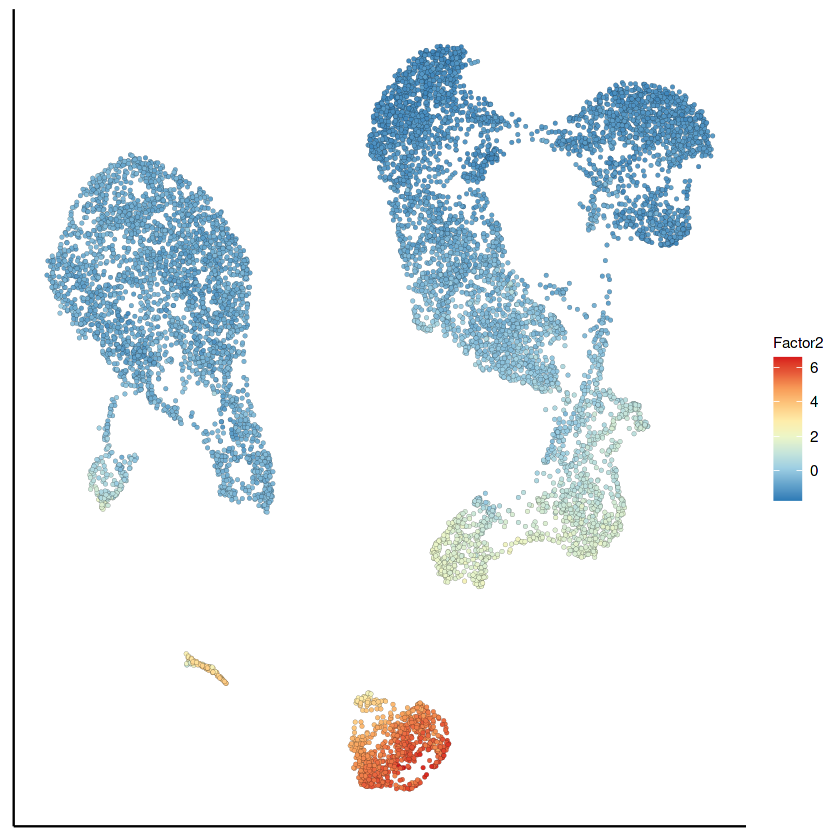

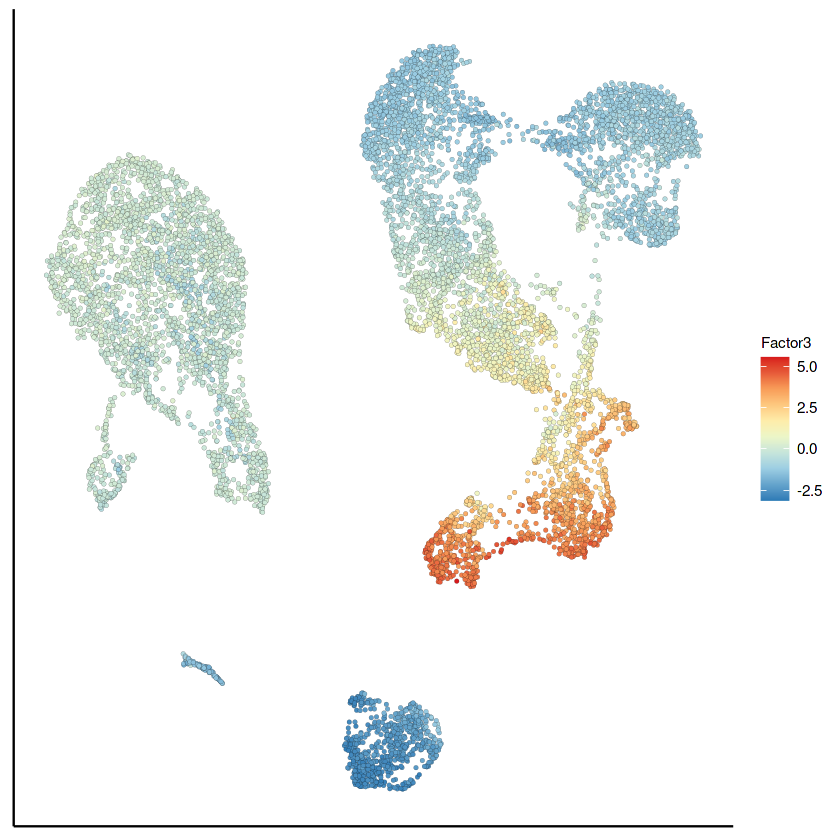

In [30]:
for (i in paste0("Factor",1:3)) {
  p <- plot_dimred(mofa, 
    method = "UMAP", 
    color_by = i, 
    stroke = 0.05, 
    dot_size = 1
  )
  print(p)
}

In this case however we notice that the resulting UMAP is not very different from the one you could obtain using the RNA expression or the ATAC data alone. This is because most, if not all, biological factors have contributions from both the RNA and ATAC modalities.



### 9.5.2 Using RNA data alone

In [32]:
DefaultAssay(seurat) <- "RNA"
seurat <- RunPCA(seurat, npcs = K, verbose = FALSE)
seurat <- RunUMAP(seurat, reduction = 'pca', dims = 1:K, verbose = FALSE)
DimPlot(seurat, label = TRUE, reduction="umap") + 
  NoLegend() + NoAxes() + scale_fill_manual(values=colors)

ERROR: Error in DefaultAssay(seurat) <- "RNA": object 'seurat' not found


### 9.5.3 Using ATAC data alone

In [ ]:
DefaultAssay(seurat) <- "ATAC_distal"
seurat <- RunSVD(seurat, n = K, verbose = FALSE)
seurat <- RunUMAP(seurat, reduction = 'lsi', dims = 1:K, verbose = FALSE)
DimPlot(seurat, label = TRUE, reduction="umap") + 
  NoLegend() + NoAxes() + scale_fill_manual(values=colors)

## 9.6 Gene set enrichment analysis

In addition to exploring the individual weights for each factor, we can use enrichment analysis to look for significant associations of factors to genesets. For more details on how GSEA works in MOFA we encourage the users to read the GSEA vignette.

### 9.6.1 Load gene set annotations

First we define the gene set matrix. We’ll use the C5 category and the Biological Process subcategory from the MSigDB data base:

In [ ]:
msgidb.matrix <- msigdbr(
  species = "Homo sapiens",
  category = "C5", 
  subcategory = "BP"
  ) %>% as.data.table %>% .[,id:=1] %>%
  dcast(gs_name~gene_symbol, value.var="id", fill=0) %>% 
  matrix.please

### 9.6.2 Run GSEA

Second, we run the enrichment analysis with default options. An important consideration when running GSEA is that MOFA Factors contain positive (+) and negative (-) weights. There will be cases where the genes with (-) weights all belong to a specific pathway but genes with (+) weights belong to other pathways. If this is true, doing GSEA with all of them together could dilute the signal. Hence, we recommend the user to do GSEA separately for (+) and (-) weights.

In [ ]:
# GSEA on positive weights
gsea.positive <- run_enrichment(mofa, 
  feature.sets = msgidb.matrix, 
  view = "RNA",
  sign = "positive"
)

# GSEA on negative weights
gsea.negative <- run_enrichment(mofa, 
  feature.sets = msgidb.matrix, 
  view = "RNA",
  sign = "negative"
)

The enrichment analysis returns a list of 5 elements:

feature.sets: the gene set matrix filtered by the genes that overlap with the MOFA model.
pval: the nominal p-values.
pval.adj: the FDR-adjusted p-values.
feature.statistics: the feature statistics (i.e. the mofa weights, by default).
set.statistics: the gene set statistics.
sigPathways: list with significant pathways per factor at a specified FDR threshold

In [ ]:
names(gsea.positive)

### 9.6.3 Visualise GSEA rsults

Factor 1 captured lineage of origin, where lymphoid cells wer linked to (-) factor values and myeloid cells to (+) factor values. Consistently, when plotting the pathways enriched in Factor 1 for (+) weight values we can see Myeloid-associated pathways:

In [ ]:
plot_enrichment(gsea.positive, factor = 1, max.pathways = 15)

and when plotting the pathways enriched in Factor 1 for (-) weight values we can see Lymphoid-associated pathways:

In [ ]:
plot_enrichment(gsea.negative, factor = 1, max.pathways = 15)

It is always advised to not rely only on the p-values and to visualise which genes are driving the enrichment within each pathways. This can be done with the plot_enrichment_detailed function.

In [ ]:
plot_enrichment_detailed(gsea.positive,
  factor = 1,
  max.genes = 10,
  max.pathways = 5
)

In [ ]:
## 9.7 Motif enrichment

Although peak annotation provides functional interpretation, it does not directly explain the underlying mechanism. Open chromatin can affect transcription through TFs, which facilitate transcription by recognizing and binding to specific DNA motifs. Let’s attempt to do motif enrichment analysis using the weights of the ATAC modality.

Here we can use the GSEA functionality implemented in MOFA. We just replace the gene set annotations by peak-motif annotations.

In [ ]:
### 9.7.1 Run

The variance explained plot suggests that there is more signal in distal peaks than in promoter peaks in the first two factors. Let’s do motif enrichment on distal peaks. Again, we compare positive weights (for Factor 1, peaks more open and motifs more enriched in Lymphoid cells) versus negative weights (for Factor 1, peaks more open and motifs more enriched in Myeloid cells)

In [ ]:
# define motif matrix
motif.matrix <- t(as.matrix(seurat[["ATAC_distal"]]@motifs@data))

# Run GSEA enrichment analysis using the motif-peak matrix, (+) weights
motif.enrichment.positive <- run_enrichment(mofa,
  view = "ATAC_distal", 
  factors = 1:2,
  feature.sets = motif.matrix,
  sign = "positive"
)

# Run GSEA enrichment analysis using the motif-peak matrix, (-) weights
motif.enrichment.negative <- run_enrichment(mofa,
  view = "ATAC_distal", 
  factors = 1:2,
  feature.sets = motif.matrix,
  sign = "negative"
)

In [ ]:
###  9.7.2 Visualise

Plot motif enrichment results for Factor 1

In [ ]:
plot_enrichment(motif.enrichment.positive, factor = 1, max.pathways = 15)

In [ ]:
plot_enrichment(motif.enrichment.negative, factor = 1, max.pathways = 15)

We can visualise the motifs using the MotifPlot function from the Signac package.

Myeloid motifs (positive Factor values): CEBPs are one of the most studied and important regulator of myeloid differentiation.

In [ ]:
sig.motifs.positive <- motif.enrichment.positive$pval.adj[,"Factor1"] %>%
  sort %>% head(n=6) %>% names
MotifPlot(seurat[["ATAC_distal"]], motifs = sig.motifs.positive)

Lymphoid motifs (negative Factor values):

LEF1 is essential for T-cell functionality.
TCFL2 also known as TCF4, is a T-cell specific TF.
RUNX3 is highly expressed in cells of lymphoid origin.
TCF7 is highly expressed in cells of lymphoid origin.
Seems like we are getting sensible results!

In [ ]:
sig.motifs.negative <- motif.enrichment.negative$pval.adj[,"Factor1"] %>%
  sort %>% head(n=6) %>% names
MotifPlot(seurat[["ATAC_distal"]], motifs = sig.motifs.negative)

9.7.3 Validation using chromVAR

To validate the motif enrichment results, we can calculate motif activity scores per cell using chromVAR. Briefly, this method computes an accessibility z-score for each motif in each cell that is adjusted by technical confounders. Positive values denote more accessible than background, and negative values denote less accessible than background

In [ ]:
seurat <- RunChromVAR(
  object = seurat, 
  assay = "ATAC_distal",
  genome = BSgenome.Hsapiens.UCSC.hg38, 
  new.assay.name = "chromvar"
)

DefaultAssay(seurat) <- "chromvar"

Indeed, the top hits for Factor 1 have very clear chromVAR patterns that distinguish lymphoid versus myeloid cells

In [ ]:
motifs.to.plot <- c(sig.motifs.positive[1:2], sig.motifs.negative[1:2])

FeaturePlot(seurat,
  features = motifs.to.plot,
  reduction = "umap",
  combine = TRUE
) & NoLegend() & NoAxes()

# 10 Conclusions

This vignette demonstrates how MOFA can be used to integrate the RNA and ATAC modalities from the Chromium Single Cell Multiome ATAC + Gene Expression assay recently introduced by 10x Genomics. I want to thank Vijay, Shamoni, Paul and Kamila from the 10x R&D team for this collaboration and for feedback on the analysis.

If you have questions, suggestions about MOFA or the vignette you can contact me by email (ricard@ebi.ac.uk). Also, we have a Slack group where we provide quick and personalised advise if you are interested in MOFA.